In [4]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# Preprocessing the Data
#1. Handle various missing values from the dataset
#2. Process the Age column into pre-defined  bins
#3. Process the Fare column into pre-defined bins
#4. Process the Cabin column , substring first letter
#5. Extract and catagorize the title from the name column
#6. Create Dummy columns from a single column 
#7. Create a package pre_process, whcih can be used for both training dataset and holdout dataset

def process_missing(df):
    """ usage: 
        holdout = process_missising(holdout)
    """
    df["Fare"] =df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"]=df["Embarked"].fillna("S")
    return df

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"]= pd.cut(df["Age"], cut_points, labels=label_names)
    return df

def process_fare(df):
    cut_points = [-1,12, 50, 100, 1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categoreis"] = pd.cut(df["Fare"], cut_points, labels = label_names)
    return df

def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin', axis=1)
    return df

def process_titles(df):
    titles = {
        "Mr" : "Mr",
        "Mme" : "Mrs",
        "Ms" : "Mrs",
        "Mrs" : "Mrs",
        "Master" : "Master",
        "Mlle" : "Miss",
        "Capt": "Officier",
        "Col": "Officier",
        "Major": "Officier",
        "Dr" : "Officier",
        "Rev" : "Officier",
        "Jonkheer" : "Royalty",
        "Don": "Royalty",
        "Sir": "Royalty",
        "Countess": "Royalty",
        "Dona" : "Royalty",
        "Lady" : "Royalty"
        
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.', expand = False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df, dummies], axis=1)
    return df

def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin (df)
    
    for col in ["Age_categories","Fare_categoreis","Title","Cabin_type", "Sex"]:
        df = create_dummies(df, col)
    return df

train = pre_process(train)
holdout = pre_process(holdout)

# Exploring data

In [11]:
# copy a dataset explore so that original dataset is safely saved
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


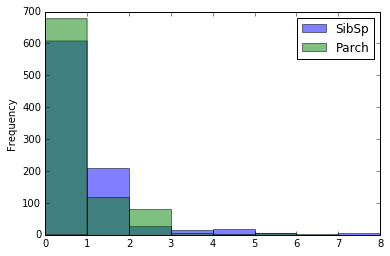

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
explore.drop("Survived", axis =1).plot.hist(alpha = 0.5, bins=8)
plt.show()
# from the chart we see the histogram 
# Parch means the number of parents or children each passenger had onvoard. Neigher column has any missing alues

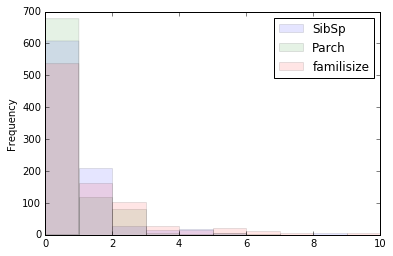

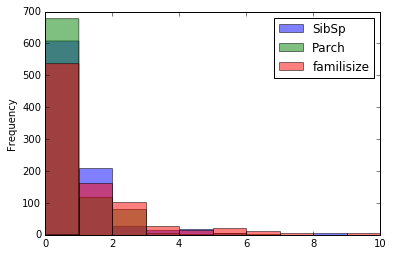

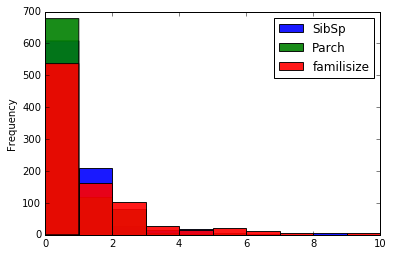

In [19]:
explore["familisize"]=explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.1, bins=10)
plt.show()
explore.drop("Survived",axis=1).plot.hist(alpha=0.5, bins=10)
plt.show()
explore.drop("Survived",axis=1).plot.hist(alpha=0.9, bins=10)
plt.show()

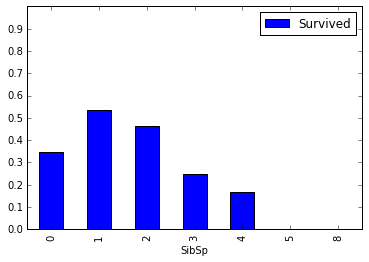

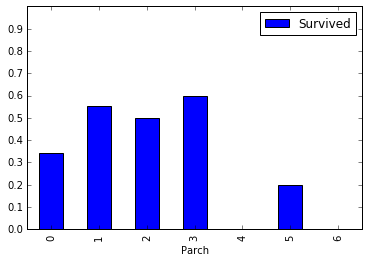

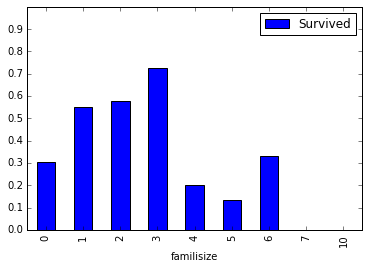

In [20]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index = col, values="Survived")
    pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,0.1))
    plt.show()

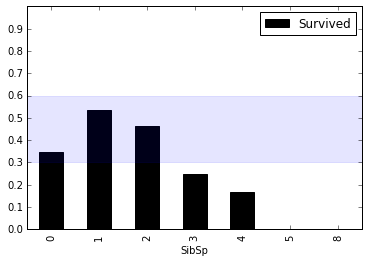

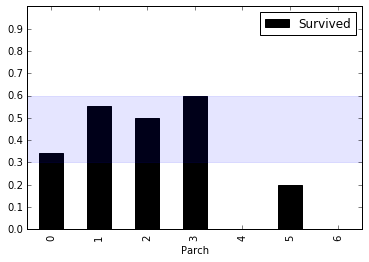

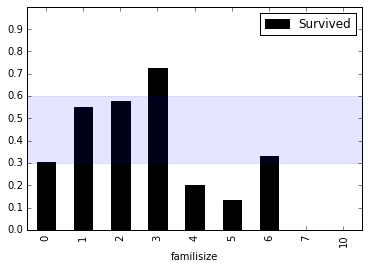

In [33]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index = col, values="Survived")
    pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,0.1), color="black")
    plt.axhspan(0.3,0.6, alpha=0.1, color="blue")
    #pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,0.1))
    plt.show()

In [36]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis = 1)
    df["isalone"] =0 
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize", axis =1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

#df.loc means row number, not index


#  Selecting the Best_Performing Features

In [ ]:
from sklearn.ensembel import RandomForestClassifier
from sklearn.feature_selection import RFECV

#1. Remove non_numeric columns
#2. Remove 100% null value columns

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)